

## Predict if someone makes more or less than 50k using the adult dataset

   * Note that this dataset strictly refers to people living in the US






In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as data_utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
# from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True

# Loading the Training and Testing Data using Data Loader 

In [2]:
# Loading the Training and Testing Data
adultdata = np.load('./Adult/data.npy').astype('float32')
adultlabels = np.load('./Adult/labels.npy').astype('float32')

## Normalizing  the data using the Formula (x-xmin/(xmax-xmin)) across each column

In [3]:
# # Normalizing the data by using the Formula (x-xmin/(xmax-xmin))
normadultdata=(adultdata-adultdata.min(axis=0))/(adultdata.max(axis=0)-adultdata.min(axis=0))

## Splitting and Loading Data in Data Loader
* Train Data Loader has shuffle = True, so that it can shuffle data in each minibatch every epoch. 

In [4]:
# Splitting the Data into Training and Test Data
X_train, X_test,Y_train,Y_test = train_test_split(normadultdata,adultlabels, test_size=0.15, shuffle = True)

# batch_size
batch = 256

# Train Data Loader
train = data_utils.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train))
train_loader = data_utils.DataLoader(train, batch_size=batch, shuffle=True)

# Test Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test))
test_loader = data_utils.DataLoader(test,batch_size=batch)

# Showing the Training Data after Normalizing

In [5]:
# Preview the training data
for batch_idx, (data, target) in enumerate(train_loader):
#     print(batch_idx)
    print("Training Data")
    print(data[0])
    print("Testing Label")
    print(target[0].item())
    break
    

Training Data
tensor([0.0137, 0.6000, 0.0000, 0.0000, 0.0918, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Testing Label
1.0


## Defining a Linear Neural Network
* A simple fully connected network was used with activation function like ReLU and PReLU. 
* PReLU was used as it increased the accuracy, although this was very experimental, as replacing all the ReLUs by PreLU significantly reduce the accuracy.
* As this is a binary classification problem, Sigmoid Activation is Used in the final layer.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(67, 128)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(32, 1)
        self.out_act = nn.Sigmoid()
    
    def swish(self,x):
        return x * torch.sigmoid(x)
        
    def forward(self, input_):
        inp = self.fc1(input_)
        x = self.relu1(inp)
        x = self.dout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dout2(x)
        x = self.fc3(x)
        x = self.prelu(x)
        x = self.out(x)
        y = (self.out_act(x))
        return y
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=67, out_features=128, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dout2): Dropout(p=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [7]:
# summary(net,input_size = (1,67),batch_size=batch)

## Network Architecture

*  As we are dealing with only 1 D data here, using  linear layers should be able to make the network give good accuracy.
* Optimizer decided was Adam as it outperformed SGD. This may be because of SGD getting stuck in local minima.
* Dropout is used for regularization. They are added after each linear layer. As I am adding dropout after each layer, a dropout of 0.2 is used.
* The weights for the first batch at each linear layer is visualized below.
* Other experiments with interchanging ReLu and PreLu can be seen in the screen shot in the ipython notebook submitted. I thought of using Prelu, as it adds a learnable parameter. But this did not help and therefore I reverted back to ReLU. 

## Visualizaing Weights

In [8]:
def plot_kernels(c, num_cols=6):
    fig = plt.figure(figsize=(num_cols,num_cols))
    for i in range(num_cols):
        ax1 = fig.add_subplot(num_cols,num_cols,i+1)
        ax1.imshow(c)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Showing the weights of the first kernel in each linear layer


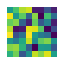

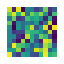

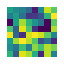

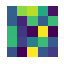

In [9]:
visnet = Net()
visnet = visnet.double()
print("Showing the weights of the first kernel in each linear layer")
for m in visnet.modules():
    if isinstance(m, nn.Linear):   
        a = m.weight.data.numpy()
#         print(tensor.max())
        c = (a - np.min(a))/np.ptp(a).astype(float)
        ncols =np.floor(np.sqrt(c.shape[1])).astype(int)
        c = np.reshape(c[0][0:ncols*ncols],(ncols,-1))
        plot_kernels(c,ncols)
#         break


##  Define a Loss function and optimizer
* Binary Cross Entropy Loss is used as this is a binary classification problem.
* After Playing with optimizers, admam gave the Best accuracy.
* Below is a table of some of the things I tried and have logged training and testing accuracy.
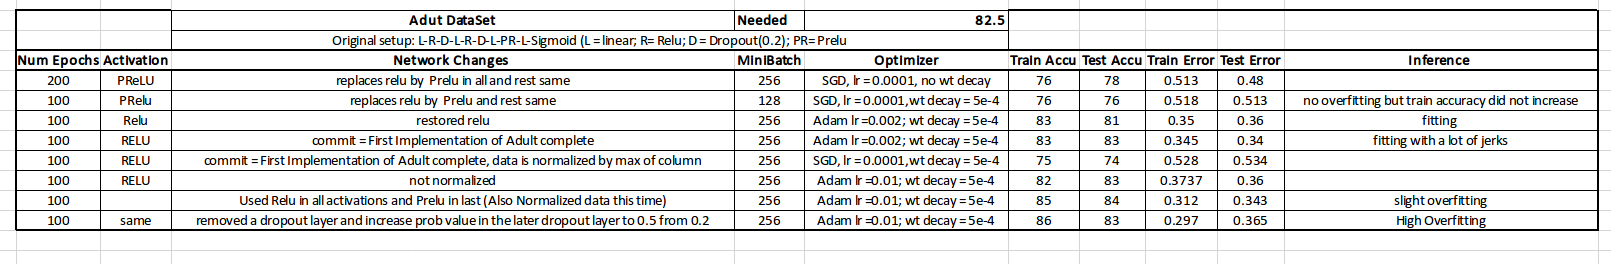
                                	
* From the above table, the original network gave the best accuracy with slight overfitting in 100 epochs. The use of dropout layers after every layer helped, but the droput was limited to 0.2. If this is increased to 0.5, the accuracy decreases.

In [10]:
import torch.optim as optim

criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)#,weight_decay = 5e-4
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps = 1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

In [11]:
# output = net(data)
# #         print(target.dtype,output.dtype)
# target = target.view(-1,1)
# loss = criterion(output, target)
# loss.backward()
# optimizer.step()
# torch.sum(output==target)



## Training and Testing

In [12]:
def train(model, train_loader, optimizer, epoch,device):
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        target = target.view(-1,1)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_correct += torch.sum(torch.round(output)==target)
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            target = target.view(-1,1)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            correct += torch.sum(torch.round(output)==target)
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
device

device(type='cuda', index=0)

# Training the Model

In [14]:
net.to(device)
epochs = 100
for epoch in range(1, epochs + 100):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/38438 (0%)]	Loss: 0.711348
Train Epoch: 1 [5120/38438 (13%)]	Loss: 0.488593
Train Epoch: 1 [10240/38438 (26%)]	Loss: 0.414672
Train Epoch: 1 [15360/38438 (40%)]	Loss: 0.440008
Train Epoch: 1 [20480/38438 (53%)]	Loss: 0.352570
Train Epoch: 1 [25600/38438 (66%)]	Loss: 0.366759
Train Epoch: 1 [30720/38438 (79%)]	Loss: 0.314764
Train Epoch: 1 [35840/38438 (93%)]	Loss: 0.342335

Test set: Average loss: 0.3633, Accuracy: 5659/6784 (83%)

Train Epoch: 2 [0/38438 (0%)]	Loss: 0.335962
Train Epoch: 2 [5120/38438 (13%)]	Loss: 0.378475
Train Epoch: 2 [10240/38438 (26%)]	Loss: 0.419595
Train Epoch: 2 [15360/38438 (40%)]	Loss: 0.360935
Train Epoch: 2 [20480/38438 (53%)]	Loss: 0.361743
Train Epoch: 2 [25600/38438 (66%)]	Loss: 0.375574
Train Epoch: 2 [30720/38438 (79%)]	Loss: 0.375083
Train Epoch: 2 [35840/38438 (93%)]	Loss: 0.373428

Test set: Average loss: 0.3547, Accuracy: 5681/6784 (83%)

Train Epoch: 3 [0/38438 (0%)]	Loss: 0.399471
Train Epoch: 3 [5120/38438 (13%)]	Loss: 0.34193

Train Epoch: 19 [15360/38438 (40%)]	Loss: 0.355883
Train Epoch: 19 [20480/38438 (53%)]	Loss: 0.317703
Train Epoch: 19 [25600/38438 (66%)]	Loss: 0.276067
Train Epoch: 19 [30720/38438 (79%)]	Loss: 0.349419
Train Epoch: 19 [35840/38438 (93%)]	Loss: 0.324101

Test set: Average loss: 0.3462, Accuracy: 5658/6784 (83%)

Train Epoch: 20 [0/38438 (0%)]	Loss: 0.297488
Train Epoch: 20 [5120/38438 (13%)]	Loss: 0.361331
Train Epoch: 20 [10240/38438 (26%)]	Loss: 0.332518
Train Epoch: 20 [15360/38438 (40%)]	Loss: 0.312351
Train Epoch: 20 [20480/38438 (53%)]	Loss: 0.351681
Train Epoch: 20 [25600/38438 (66%)]	Loss: 0.343404
Train Epoch: 20 [30720/38438 (79%)]	Loss: 0.324105
Train Epoch: 20 [35840/38438 (93%)]	Loss: 0.346404

Test set: Average loss: 0.3481, Accuracy: 5682/6784 (83%)

Train Epoch: 21 [0/38438 (0%)]	Loss: 0.354704
Train Epoch: 21 [5120/38438 (13%)]	Loss: 0.263834
Train Epoch: 21 [10240/38438 (26%)]	Loss: 0.344916
Train Epoch: 21 [15360/38438 (40%)]	Loss: 0.385798
Train Epoch: 21 [20480/38

Train Epoch: 37 [10240/38438 (26%)]	Loss: 0.295978
Train Epoch: 37 [15360/38438 (40%)]	Loss: 0.296213
Train Epoch: 37 [20480/38438 (53%)]	Loss: 0.277207
Train Epoch: 37 [25600/38438 (66%)]	Loss: 0.318695
Train Epoch: 37 [30720/38438 (79%)]	Loss: 0.362894
Train Epoch: 37 [35840/38438 (93%)]	Loss: 0.310824

Test set: Average loss: 0.3469, Accuracy: 5677/6784 (83%)

Train Epoch: 38 [0/38438 (0%)]	Loss: 0.347162
Train Epoch: 38 [5120/38438 (13%)]	Loss: 0.342667
Train Epoch: 38 [10240/38438 (26%)]	Loss: 0.337852
Train Epoch: 38 [15360/38438 (40%)]	Loss: 0.335819
Train Epoch: 38 [20480/38438 (53%)]	Loss: 0.280365
Train Epoch: 38 [25600/38438 (66%)]	Loss: 0.270310
Train Epoch: 38 [30720/38438 (79%)]	Loss: 0.345794
Train Epoch: 38 [35840/38438 (93%)]	Loss: 0.365651

Test set: Average loss: 0.3530, Accuracy: 5640/6784 (83%)

Train Epoch: 39 [0/38438 (0%)]	Loss: 0.310098
Train Epoch: 39 [5120/38438 (13%)]	Loss: 0.315618
Train Epoch: 39 [10240/38438 (26%)]	Loss: 0.329374
Train Epoch: 39 [15360/38

Train Epoch: 55 [5120/38438 (13%)]	Loss: 0.285154
Train Epoch: 55 [10240/38438 (26%)]	Loss: 0.334726
Train Epoch: 55 [15360/38438 (40%)]	Loss: 0.279515
Train Epoch: 55 [20480/38438 (53%)]	Loss: 0.237306
Train Epoch: 55 [25600/38438 (66%)]	Loss: 0.342619
Train Epoch: 55 [30720/38438 (79%)]	Loss: 0.326233
Train Epoch: 55 [35840/38438 (93%)]	Loss: 0.323717

Test set: Average loss: 0.3466, Accuracy: 5658/6784 (83%)

Train Epoch: 56 [0/38438 (0%)]	Loss: 0.332384
Train Epoch: 56 [5120/38438 (13%)]	Loss: 0.305028
Train Epoch: 56 [10240/38438 (26%)]	Loss: 0.332737
Train Epoch: 56 [15360/38438 (40%)]	Loss: 0.252788
Train Epoch: 56 [20480/38438 (53%)]	Loss: 0.279908
Train Epoch: 56 [25600/38438 (66%)]	Loss: 0.275071
Train Epoch: 56 [30720/38438 (79%)]	Loss: 0.327507
Train Epoch: 56 [35840/38438 (93%)]	Loss: 0.329703

Test set: Average loss: 0.3496, Accuracy: 5682/6784 (83%)

Train Epoch: 57 [0/38438 (0%)]	Loss: 0.297885
Train Epoch: 57 [5120/38438 (13%)]	Loss: 0.301646
Train Epoch: 57 [10240/384


Test set: Average loss: 0.3517, Accuracy: 5685/6784 (83%)

Train Epoch: 73 [0/38438 (0%)]	Loss: 0.313381
Train Epoch: 73 [5120/38438 (13%)]	Loss: 0.291884
Train Epoch: 73 [10240/38438 (26%)]	Loss: 0.365852
Train Epoch: 73 [15360/38438 (40%)]	Loss: 0.316145
Train Epoch: 73 [20480/38438 (53%)]	Loss: 0.332497
Train Epoch: 73 [25600/38438 (66%)]	Loss: 0.342998
Train Epoch: 73 [30720/38438 (79%)]	Loss: 0.304132
Train Epoch: 73 [35840/38438 (93%)]	Loss: 0.322837

Test set: Average loss: 0.3474, Accuracy: 5685/6784 (83%)

Train Epoch: 74 [0/38438 (0%)]	Loss: 0.308800
Train Epoch: 74 [5120/38438 (13%)]	Loss: 0.312675
Train Epoch: 74 [10240/38438 (26%)]	Loss: 0.324675
Train Epoch: 74 [15360/38438 (40%)]	Loss: 0.285380
Train Epoch: 74 [20480/38438 (53%)]	Loss: 0.330818
Train Epoch: 74 [25600/38438 (66%)]	Loss: 0.262391
Train Epoch: 74 [30720/38438 (79%)]	Loss: 0.331654
Train Epoch: 74 [35840/38438 (93%)]	Loss: 0.315720

Test set: Average loss: 0.3478, Accuracy: 5691/6784 (83%)

Train Epoch: 75 


Test set: Average loss: 0.3502, Accuracy: 5700/6784 (84%)

Train Epoch: 91 [0/38438 (0%)]	Loss: 0.317252
Train Epoch: 91 [5120/38438 (13%)]	Loss: 0.298028
Train Epoch: 91 [10240/38438 (26%)]	Loss: 0.271551
Train Epoch: 91 [15360/38438 (40%)]	Loss: 0.324027
Train Epoch: 91 [20480/38438 (53%)]	Loss: 0.289529
Train Epoch: 91 [25600/38438 (66%)]	Loss: 0.289386
Train Epoch: 91 [30720/38438 (79%)]	Loss: 0.312218
Train Epoch: 91 [35840/38438 (93%)]	Loss: 0.365561

Test set: Average loss: 0.3508, Accuracy: 5674/6784 (83%)

Train Epoch: 92 [0/38438 (0%)]	Loss: 0.308407
Train Epoch: 92 [5120/38438 (13%)]	Loss: 0.266076
Train Epoch: 92 [10240/38438 (26%)]	Loss: 0.312920
Train Epoch: 92 [15360/38438 (40%)]	Loss: 0.339843
Train Epoch: 92 [20480/38438 (53%)]	Loss: 0.313513
Train Epoch: 92 [25600/38438 (66%)]	Loss: 0.345598
Train Epoch: 92 [30720/38438 (79%)]	Loss: 0.320727
Train Epoch: 92 [35840/38438 (93%)]	Loss: 0.362900

Test set: Average loss: 0.3503, Accuracy: 5665/6784 (83%)

Train Epoch: 93 

Training Loss: 0.3106571157641758
Training Accuracy: tensor(85, device='cuda:0')

Test Loss: 0.34886841089637194
Testing Accuracy: tensor(83, device='cuda:0')



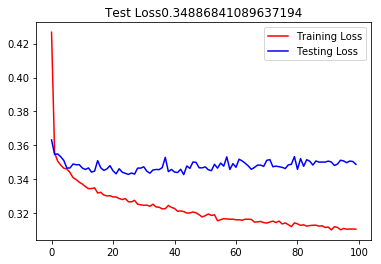

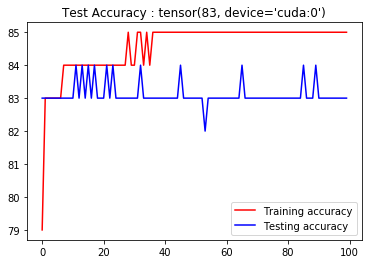

In [15]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', val_loss[-1])
print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(test_accu[-1]))
plt.legend()
plt.show()

# Incorrect Predictions


In [16]:
# Visualize Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test))
visualize_loader = data_utils.DataLoader(test)

In [17]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
n = 6   # Number of False predictions to output
for data, target in visualize_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========0`
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    neg = (torch.round(output)!=target).item()
    pred= torch.round(output).item()
    predictedlabel.append(pred)
    targetlabel.append(target)
    ind.append(neg)
    
    
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]
print("The Top 6 Wrong Predictions are as follows")
for i in range(n):
    print()
    print("Wrong Prediciton No "+ str(i+1))
    print ("Input: "+ str(X_test[maxerrorind[i]]))
    print("Predicted label"+ str(predictedlabel[[maxerrorind[i]]]))
    print("True label"+ str(targetlabel[[maxerrorind[i]]]))

    

/home/anirudh/anaconda2/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


The Top 6 Wrong Predictions are as follows

Wrong Prediciton No 1
Input: [0.6712329  0.53333336 0.         0.         0.3469388  0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 1.         0.         1.         0.         0.         0.
 0.        ]
Predicted label[1.]
True label[0.]

Wrong Prediciton No 2
Input: [0.19178082 0.53333336 0.03162055 0.         0.39795917 0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

## Positive Predictions

In [18]:
ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]
print("Positive Predictions are as follows")
for i in range(n):
    print()
    print("Positive Prediciton No "+ str(i+1))
    print ("Input: "+ str(X_test[maxerrorind[i]]))
    print("Predicted label"+ str(predictedlabel[[maxerrorind[i]]]))
    print("True label"+ str(targetlabel[[maxerrorind[i]]]))


Positive Predictions are as follows

Positive Prediciton No 1
Input: [0.05479452 0.53333336 0.         0.         0.19387755 0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         1.         0.
 0.         1.         1.         0.         0.         0.
 0.        ]
Predicted label[1.]
True label[1.]

Positive Prediciton No 2
Input: [0.05479452 0.53333336 0.         0.         0.19387755 0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0